# System Identification

System identification is the process of finding a transfer function that predicts the measured output
of an open loop system for different values of its control input.
In practice, accuracy is assessed by comparisons with
wet lab experiments.
In this notebook, our "experimental data" are simulation studies.

System identification involves
iteratively choosing the number of zeros and poles and potentially adjusting the operating region as well.
For each specification of zeros, poles, and operating region, a fit is done to find the best transfer function for
the experimental data.

## Preliminaries

In [1]:
import numpy as np
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl

import matplotlib.pyplot as plt
import control
import numpy as np
import pandas as pd
try:
    import tellurium as te
except:
    !pip install -q controlSBML
    import tellurium as te
ctl.__version__

'1.2.4'

In [2]:
s = control.TransferFunction.s

## Models

### SEQUENTIAL_MODEL

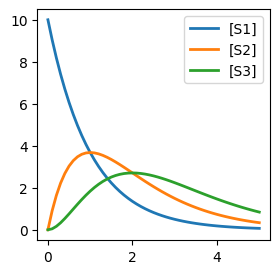

In [3]:
SEQUENTIAL_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
end
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate()
rr.plot(figsize=(3,3))

In [4]:
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, input_name="S1", output_name="S3")

### WOLF_MODEL

In [5]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_name="at_", output_name="s5")
print(WOLF_MODEL)

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

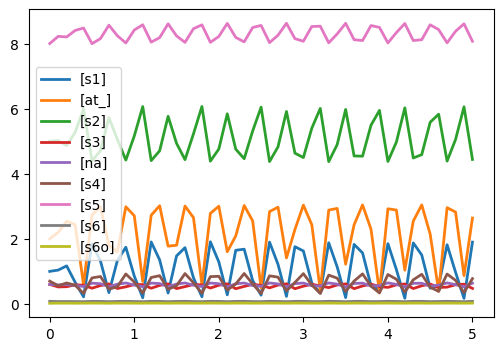

In [6]:
rr = te.loada(WOLF_MODEL)
rr.simulate()
rr.plot()

### MTOR_MODEL

In [7]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_name="DEPTOR", output_name="mTORC1")
print(MTOR_MODEL)

// Created by libAntimony v2.15.0
model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in compartment_, pIR in compartment_, IRS in compartment_, pIRS in compartment_;
  species iIRS in compartment_, Akt in compartment_, pAkt in compartment_;
  species mTORC1 in compartment_, pmTORC1 in compartment_, mTORC2 in compartment_;
  species pmTORC2 in compartment_, imTORC2 in compartment_, mTORC1_DEPTOR in compartment_;
  species mTORC2_DEPTOR in compartment_, DEPTOR in compartment_, pDEPTOR in compartment_;

  // Reactions:
  v1: IR => pIR; compartment_*(V1*IR/(Km1 + IR));
  v2: pIR => IR; compartment_*(V2*pIR/(Km2 + pIR));
  v3: IRS => pIRS; compartment_*(k3c*IRS*pIR/(Km3 + IRS));
  v4: pIRS => IRS; compartment_*(V4*pIRS/(Km4 + pIRS));
  v5: Akt => pAkt; compartment_*(k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt));
  v6: pAkt => Akt

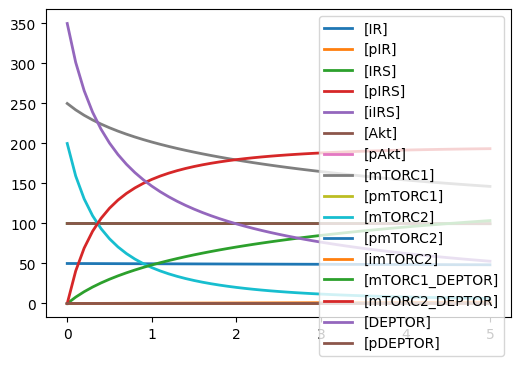

In [8]:
rr = te.loada(MTOR_MODEL)
rr.simulate()
rr.plot()

# Sequential model system identification

In this section, we use SEQUENTIAL_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Determine the operating region

The operating region is the range of control inputs that should handled by the controller.
We want to see how responsive the system is to the possible outputs from the controller.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

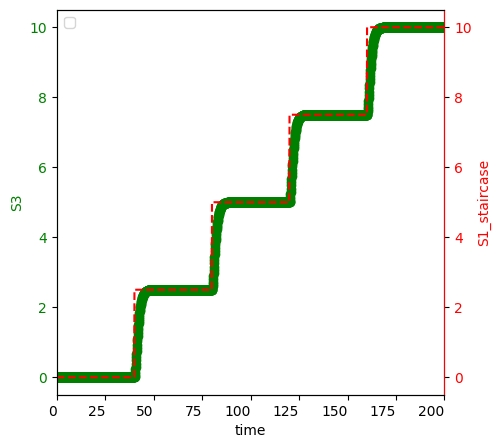

In [9]:
STAIRCASE = SEQUENTIAL_CTLSB.plotStaircaseResponse(times=np.linspace(0, 200, 2000),
        num_step=4)

Operating region:
* step duration: 50 s
* control input in [1, 10]
* measured output in [0, 10]

## Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials for the transfer function.

In [10]:
?SEQUENTIAL_CTLSB.plotTransferFunctionFit

Signature:
SEQUENTIAL_CTLSB.plotTransferFunctionFit(
    num_zero: int = 1,
    num_pole: int = 3,
    fit_start_time: Optional[float] = None,
    fit_end_time: Optional[float] = None,
    initial_value: Optional[float] = None,
    final_value: Optional[float] = None,
    num_step: Optional[int] = 5,
    fitter_method: Optional[str] = 'poly',
    times: Optional[numpy.ndarray] = None,
    **kwargs,
) -> controlSBML.control_sbml.TransferFunctionFitResult
Docstring:
Simulates the staircase response and plots it. Sets the fitter result.

Args:
    num_zero: int (number of zeros)
    num_pole: int (number of poles)
    fit_start_time: float (time at which fitting starts)
    fit_end_time: float (time at which fitting ends)
    initial_value: float (initial value of staircase)
    final_value: float (final value of staircase)
    num_step: int (number of steps in staircase)
    times: numpy array (times of simulation)
    fitter:method: str
        'poly' uses a polynomial fit
        'gpz'

Transfer functions
* no zero, one pole: $\frac{k_1}{s + k_2}$
* no zero, two poles: $\frac{k_1}{(s + k_2)(s + k_3)}$
* 1 zero, two poles: $\frac{k_1s + k_3}{(s + k_2)(s + k_3)}$

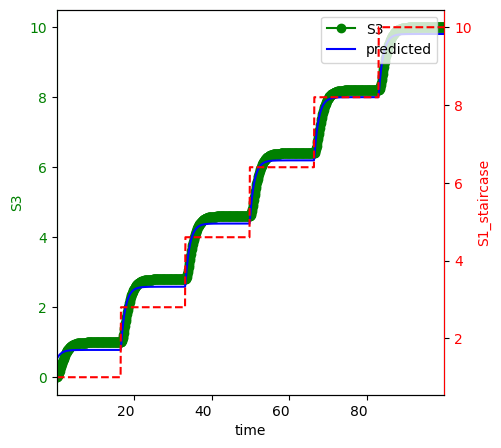

In [11]:
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=1,
            initial_value=1, final_value=10,
            times=np.linspace(0, 100, 1000))

The solid blue line is the predicted value.
The green line are predictions from the transfer function.

We want the green line to mostly be coincident with the blue line, especially when the blue line is flat (steady state).

In [12]:
SEQUENTIAL_TF = SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()
SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()

TransferFunction(array([6.77822123]), array([7.52001262, 6.76113213]))

Now check that the results are consistent with the plot. The DC gain should be the ratio of the upper limit of the left axis with the upper limit of the right axis. DC gain should be fairly insensitive to the size of the time step.

In [13]:
SEQUENTIAL_TF.dcgain()

1.0025275501898476

The poles should indicate the transient response. A very negative real part indicates short settling times. A non-zero imaginary part should be reflected in terms of overshoot/undershoot (depending on the size of the time steps). The magnitude of poles will change with the size of the time step, but their signs should not change.

In [14]:
SEQUENTIAL_TF.poles()

array([-0.89908521+0.j])

#  Wolf Transfer Function

In [15]:
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_name="s1", output_name="s5")

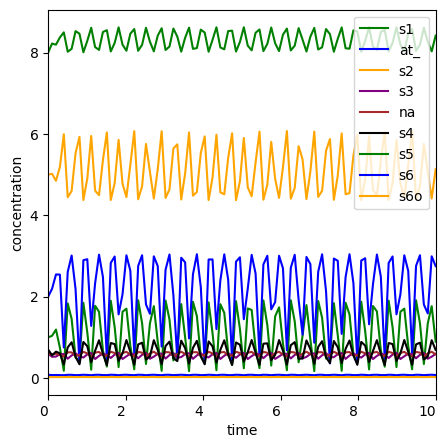

In [16]:
_ = WOLF_CTLSB.plotModel()

## Determine the operating region

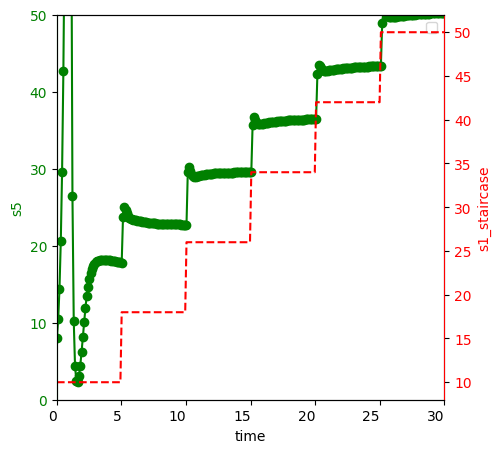

In [17]:
_ = WOLF_CTLSB.plotStaircaseResponse(times=np.linspace(0, 30, 300),
    initial_value=10, final_value=50, ylim=[0, 50])

**Quetion: Is this a reasonable operating region?**

## Find the transfer function

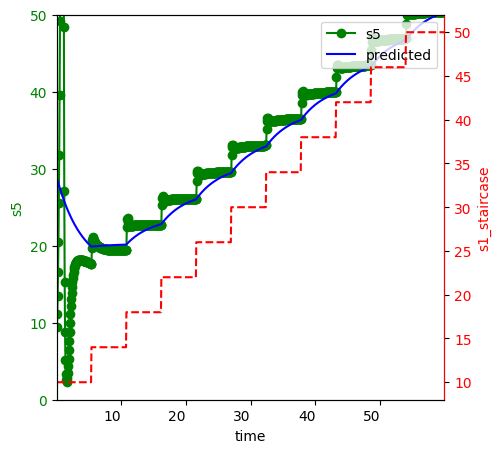

In [18]:
_ = WOLF_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 60, 1000),
            num_zero=0, num_pole=1,
            num_step=10,
            ylim=[0, 50],
            fit_start_time=0,
            initial_value=10, final_value=50)

The problem here is that the initial transient distorts the input/output relationship. We need to discard the early part to better fit the transfer function. ``fit_start_time`` indicates when the fit should begin.

In [19]:
tf = WOLF_CTLSB.getOpenLoopTransferFunction()
print(tf)


     6.27
---------------
28.55 s + 7.265



In [20]:
tf.poles()

array([-0.25442521+0.j])

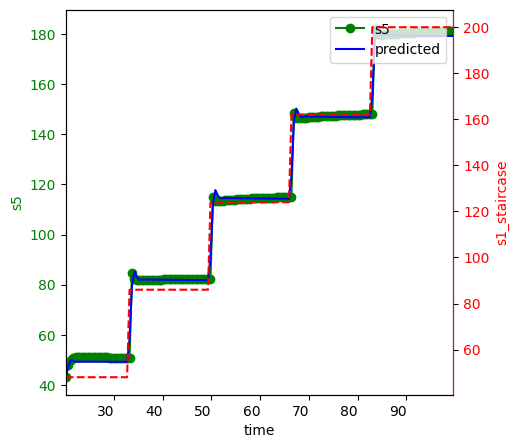

In [21]:
_ = WOLF_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 100, 200), initial_value=10, final_value=200,
                                      fit_start_time=20)

In [22]:
WOLF_TF = WOLF_CTLSB.getOpenLoopTransferFunction()
print(WOLF_TF)


             5.481e+04 s + 5692
---------------------------------------------
5695 s^3 + 2.282e+04 s^2 + 6.547e+04 s + 6667



In [23]:
WOLF_TF.poles()

array([-1.95108556+2.69766037j, -1.95108556-2.69766037j,
       -0.10562571+0.j        ])

In [24]:
WOLF_TF.dcgain()

0.8537434541007448

# Exercise: mTOR transfer function

In [25]:
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_name="V1", output_name="pmTORC1")

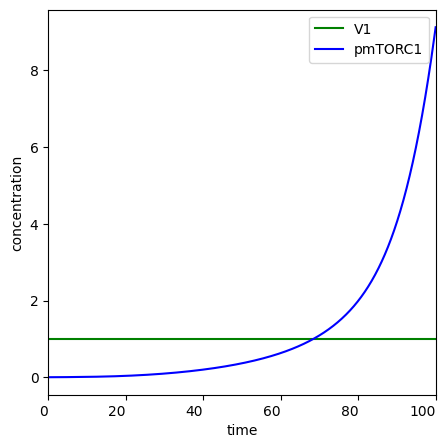

In [26]:
_ = MTOR_CTLSB.plotModel(selections=["time", "V1", "pmTORC1"], times=np.linspace(0, 100, 1000))

## Determine the operating region

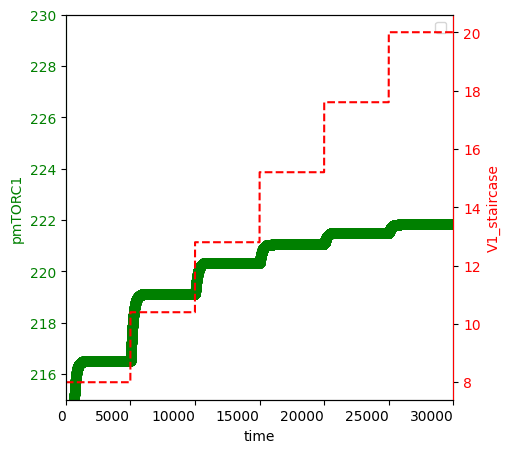

In [27]:
_ = MTOR_CTLSB.plotStaircaseResponse(times=np.linspace(0, 30000, 300000),
    initial_value=8, final_value=20, ylim=[215, 230])

**Question: Is this a reasonable operating region?**

## Find the transfer function